<h1 align="center"> Credit card Fraud Detector </h1>


<h2> Введение </h2>

На данной практие (и еще на парочке занятий потом) мы будем реализовывать различные прогностические модели, чтобы проверить, насколько точно они определяют, является ли транзакция обычным платежом (non Fraud) или мошенничеством (Fraud).

<h4> По мотивам кейса, рассмотренного в Зимней школе СберУнивера </h4>

<h2> Наши цели: </h2>
<ul>
<li> Проанализировать полученные данные. </li>
<li> Рассмотреть проблему сильного дисбаланса классов. </li>
<li> Использовать алгоритмы кластеризации </li>
<li> Использовать алгоритмы понижения размерности </li>


## Описание данных и постановка задачи:
**Задача:** Банкам, выпускающим кредитные карты, очень важно распознавать мошеннические операции с кредитными картами, чтобы с клиентов не взималась плата за товары, которые они не покупали.

**Данные**: Набор данных содержит транзакции, совершенные по кредитным картам в сентябре 2013 года европейскими держателями карт.
В этом наборе данных представлены транзакции, проведенные за два дня, где мы имеем 492 случаев мошенничества из 284 807 транзакций. Набор данных сильно несбалансирован, положительный класс (мошенники) составляет всего 0,172% от всех транзакций.

Датасет содержит только числовые входные переменные, которые являются результатом преобразования PCA (метод главных компонент).

Из-за вопросов конфиденциальности невозможно использовать исходные признаки и более подробную информацию о них. Характеристики V1, V2, ... V28 - это главные компоненты, полученные с помощью PCA, единственные характеристики, которые не были преобразованы с помощью PCA - это "Time" и "Amount". Столбец "Time" содержит секунды, прошедшие между каждой транзакцией и первой транзакцией в наборе данных. Столбец "Amount" - это сумма транзакции. Столбец "Class" является переменной отклика и принимает значение 1 в случае мошенничества и 0 в противном случае.





In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline


import seaborn as sns
import matplotlib.patches as mpatches
import time

import collections
from collections import Counter

import warnings
warnings.filterwarnings("ignore")

Подключимся к диску для загрузки данных.

Загружаем данные:
'creditcard.csv'

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# загрузка данных и структура данных
df=pd.read_csv('/content/drive/MyDrive/Data_Analysis/creditcard.csv')

df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


Небольшой описательный анализ.

In [6]:
# анализ данных
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,...,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


Проверим на наличие пропусков в данных.

In [ ]:
# проверка наличия пропусков в данных
df.isnull().sum()


Пропусков нет?

Выведем названия столбцов.

In [10]:
# названия столбцов
for index in df.columns:
    print(index)

Time
V1
V2
V3
V4
V5
V6
V7
V8
V9
V10
V11
V12
V13
V14
V15
V16
V17
V18
V19
V20
V21
V22
V23
V24
V25
V26
V27
V28
Amount
Class


Еще раз оценим отношение классов целевой переменной.

In [13]:
# вывод на печать 'Обычные транзакции составляют' и 'Мошеннические транзакции составляют' в процентном соотношении

import pandas as pd

total_transactions = len(df)

fraud_transactions = df['Class'].value_counts()[1]
normal_transactions = df['Class'].value_counts()[0]

fraud_percentage = (fraud_transactions / total_transactions) * 100
normal_percentage = (normal_transactions / total_transactions) * 100

print(f"Обычные транзакции составляют: {normal_percentage:.2f}%")
print(f"Мошеннические транзакции составляют: {fraud_percentage:.2f}%")


Обычные транзакции составляют: 99.83%
Мошеннические транзакции составляют: 0.17%


**Важно!**

Обратите внимание, насколько несбалансированным является наш исходный набор данных! Большинство транзакций не являются мошенническими. Если мы используем этот массив данных в качестве основы для наших моделей прогнозирования и анализа, мы можем получить много ошибок, поскольку наши алгоритмы будут предполагать, что все транзакции не являются мошенничеством. Нам же критически важно сконцентрироваться именно на мошенниках.

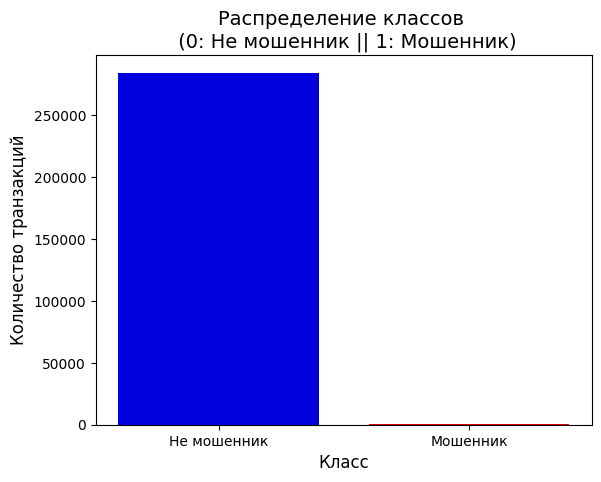

In [19]:
import pandas as pd
import matplotlib.pyplot as plt

colors = ["#0101DF", "#DF0101"]

 # строим гистограмму целевой переменной:

class_counts = df['Class'].value_counts()

# Построение гистограммы
plt.bar(class_counts.index, class_counts.values, color=colors)
plt.title('Распределение классов \n (0: Не мошенник || 1: Мошенник)', fontsize=14)
plt.xticks([0, 1], ['Не мошенник', 'Мошенник'])
plt.ylabel('Количество транзакций', fontsize=12)
plt.xlabel('Класс', fontsize=12)

# Показ графика
plt.show()

Построим распределения по суммам и времени транзакций.

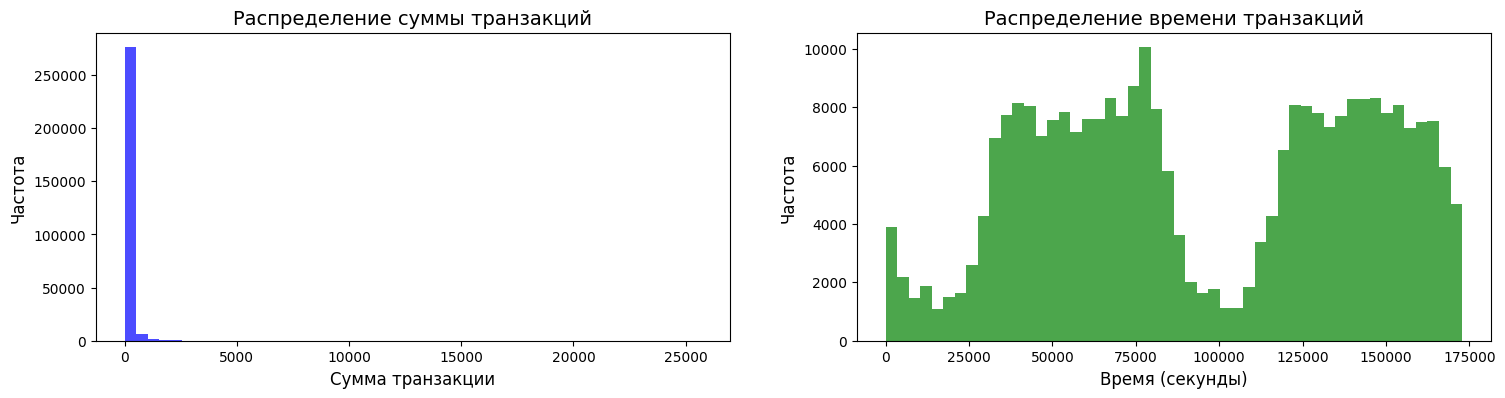

In [20]:
# Извлечение значений столбцов 'Amount' и 'Time'
amount_val = df['Amount']
time_val = df['Time']

# Создание двух подграфиков
fig, ax = plt.subplots(1, 2, figsize=(18, 4))

# Построение графика распределения суммы транзакций
ax[0].hist(amount_val, bins=50, color='blue', alpha=0.7)
ax[0].set_title('Распределение суммы транзакций', fontsize=14)
ax[0].set_xlabel('Сумма транзакции', fontsize=12)
ax[0].set_ylabel('Частота', fontsize=12)

# Построение графика распределения времени транзакций
ax[1].hist(time_val, bins=50, color='green', alpha=0.7)
ax[1].set_title('Распределение времени транзакций', fontsize=14)
ax[1].set_xlabel('Время (секунды)', fontsize=12)
ax[1].set_ylabel('Частота', fontsize=12)

# Отображение графиков
plt.show()


### Масштабирование
Первым делом нам необходимо отмасштабировать столбцы **Time** и **Amount**. Поскольку все остальные признаки уже отмасштабированы. Однако делать это нужно только строго **после** разбиения на обучающую выборку и тестовую.

Затем необходимо создать подвыборку из наших данных, чтобы иметь равное количество случаев мошенничества и не мошенничества, что поможет нашим моделям лучше понять закономерности, определяющие, является ли транзакция мошенничеством или нет.

### Зачем создавать подвыборку?
Наши данные имеют сильный дисбаланс. Использование исходного датасета приведет к следующим проблемам:
  - **Переобучение**: Наши модели классификации будут предполагать, что в большинстве случаев мошенничества не существует! Мы хотим, чтобы наша модель точно определяла, когда происходит мошенничество.
  - **Неверные корреляции:** Хотя мы не знаем, что обозначают признаки "V", будет полезно понять, как каждый из этих признаков влияет на результат (мошенничество или отсутствие мошенничества), поскольку, имея несбалансированный набор данных, мы не можем увидеть истинные корреляции между целевой переменной и признаками.

### Разделение данных
**Важно!**

Прежде, чем приступить к балансировке наших данных, мы должны разделить исходный набор данных. Зачем?

Для определения качества работы наших моделей их необходимо тестировать на **исходном** тестовом наборе, а не на тестовом наборе, созданном после балансировки. Цель балансировки заключается в том, чтобы модель смогла найти закономерности для принятия решения по типу транзакции, поэтому мы выравниваем соотношение между мошенническими транзакциями и обычными. Однако проверять качество мы будем именно в "боевых" условиях с учетом реального распределения данных.




In [22]:
from sklearn.model_selection import train_test_split
# Поскольку большая часть наших данных уже масштабирована, мы должны масштабировать столбцы,
# которые остались (Amount и Time)
from sklearn.preprocessing import RobustScaler

rob_scaler = RobustScaler() # Менее чувствителен к выбросам, чем просто стандартизация

X = df.drop('Class', axis=1)
y = df['Class']

original_Xtrain, original_Xtest, original_ytrain, original_ytest = train_test_split(X, y, test_size=0.2,
                                                                                    random_state = 42)


# Посмотрим, какие типы данных возвращаются после разделения:
rt_tmp = original_Xtrain['Amount']
print (f'Тип данных original_Xtrain["Amount"] {type(rt_tmp)}')
print (f'Тип данных original_Xtrain["Amount"].values {type(rt_tmp.values)}')
print (f'Данные original_Xtrain["Amount"].values {rt_tmp.values}')
print (f'Тип данных original_Xtrain["Amount"].values.reshape(-1,1) {type(rt_tmp.values.reshape(-1,1))}')
print (f'Данные original_Xtrain["Amount"].values.reshape(-1,1) \n{rt_tmp.values.reshape(-1,1)} \n')

# вот последнее представление - как раз то, что нужно для RobustScaler . Преобразовываем так все нужные столбцы.

original_Xtrain['scaled_amount'] = rob_scaler.fit_transform(original_Xtrain['Amount'].values.reshape(-1,1))
original_Xtest['scaled_amount'] = ...

original_Xtrain['scaled_time'] = ...
original_Xtest['scaled_time'] = ...

original_Xtrain.drop(['Time','Amount'], axis=1, inplace=True)
original_Xtest.drop(['Time','Amount'], axis=1, inplace=True)

original_Xtrain = original_Xtrain.values
original_Xtest = original_Xtest.values
original_ytrain = original_ytrain.values
original_ytest = original_ytest.values

train_unique_label, train_counts_label = np.unique(original_ytrain, return_counts=True)
test_unique_label, test_counts_label = np.unique(original_ytest, return_counts=True)

print('Распределение классов: \n')
print("Обучающий набор:", train_counts_label/ len(original_ytrain))
print("Тестовый набор:", test_counts_label/ len(original_ytest))

Тип данных original_Xtrain["Amount"] <class 'pandas.core.series.Series'>
Тип данных original_Xtrain["Amount"].values <class 'numpy.ndarray'>
Данные original_Xtrain["Amount"].values [  9.99  45.9   11.99 ...   3.94   1.   113.  ]
Тип данных original_Xtrain["Amount"].values.reshape(-1,1) <class 'numpy.ndarray'>
Данные original_Xtrain["Amount"].values.reshape(-1,1) 
[[  9.99]
 [ 45.9 ]
 [ 11.99]
 ...
 [  3.94]
 [  1.  ]
 [113.  ]] 

Распределение классов: 

Обучающий набор: [0.99827075 0.00172925]
Тестовый набор: [0.99827955 0.00172045]


## Метод Random Under-Sampling

Применим метод *Random Under-Sampling*, который случайным образом удаляет объекты доминирующего класса и выравнивает соотношение классов.

#### Алгоритм:
<ul>
<li>Определяем степень несбалансированности (посчитали количество меток одного и другого класса выше)  </li>
<li>Как только мы определим, сколько случаев считаются мошенническими операциями (Fraud = "1"), мы должны довести количество немошеннических операций до того же количества, что и мошеннических (мы хотим получить соотношение 50/50 между классами), то есть это в подвыборке будет 492 случая мошенничества и 492 случая немошеннических операций.  </li>
<li> После применения этого метода мы получим подвыборку нашего набора данных с соотношением 50/50 в отношении наших классов. Наконец, не забудем <b>перемешать</b> наши данные для того, чтобы модели не зависили от порядка входных данных.</li>
</ul>

**Важно!**

Основная проблема данного метода заключается в том, что мы рискуем тем, что наши модели классификации не будут работать так точно, как нам хотелось бы, поскольку происходит большая потеря информации (выделение всего 492 немошеннических транзакций из 284 315 немошеннических транзакций).

In [23]:
# Поскольку наши классы сильно не сбалансированы, мы должны сделать их эквивалентными,
# чтобы получить нормальное распределение классов.

# Перемешаем данные перед созданием подвыборок

df = df.sample(frac=1)

fraud_df = df.loc[df['Class'] == 1]
non_fraud_df = df.loc[df['Class'] == 0][:492] # берем последние 492 транзакции

normal_distributed_df = pd.concat([fraud_df, non_fraud_df])

# Перемешивание строк датасета
new_df = normal_distributed_df.sample(frac=1, random_state=42)

new_df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
239999,150379.0,-0.252913,0.727518,0.278343,-0.774979,0.972262,-0.810427,1.370595,-0.643502,0.513952,...,-0.421468,-0.557867,0.079847,-0.422276,-0.421373,0.110196,-0.067435,-0.307913,11.36,0
42756,41233.0,-10.645800,5.918307,-11.671043,8.807369,-7.975501,-3.586806,-13.616797,6.428169,-7.368451,...,2.571970,0.206809,-1.667801,0.558419,-0.027898,0.354254,0.273329,-0.152908,0.00,1
238571,149726.0,-4.656928,-2.746992,0.411954,-1.686510,1.120796,-1.847821,-1.094822,0.865696,0.213467,...,-0.130532,-0.877283,-1.292874,-0.168126,0.178224,0.261597,0.474589,-1.008187,163.16,0
88897,62341.0,-5.267760,2.506719,-5.290925,4.886134,-3.343188,-1.100085,-5.810509,1.726343,-0.749277,...,0.764266,0.473262,0.548482,-0.156850,-0.710187,-0.366423,-1.486766,0.677664,1.10,1
26802,34256.0,0.539276,1.554890,-2.066180,3.241617,0.184736,0.028330,-1.515521,0.537035,-1.999846,...,0.371773,0.111955,-0.305225,-1.053835,0.771175,0.240878,0.418435,0.232170,19.02,1


In [ ]:
df.to_csv("/content/drive/MyDrive/Colab Notebooks/data/creditcard_full.csv")

In [ ]:
new_df.shape

(984, 31)

Class
0    492
1    492
Name: count, dtype: int64


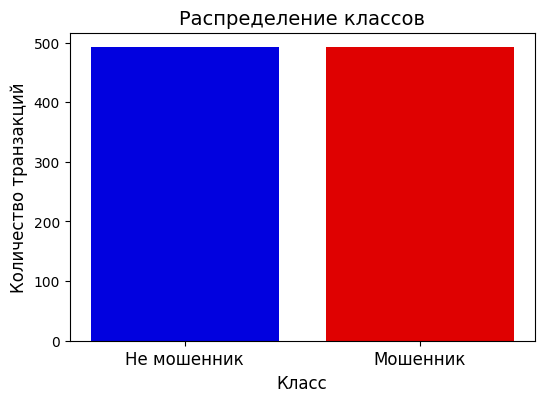

In [26]:
# проверяем снова распределение целевой переменной
print(new_df['Class'].value_counts())

# Построение графика для визуализации распределения классов
import matplotlib.pyplot as plt
plt.figure(figsize=(6, 4))
class_counts = new_df['Class'].value_counts()
colors = ["#0101DF", "#DF0101"]  # Синий для обычных, красный для мошеннических
plt.bar(class_counts.index, class_counts.values, color=colors)
plt.title('Распределение классов', fontsize=14)
plt.xticks([0, 1], ['Не мошенник', 'Мошенник'], fontsize=12)
plt.ylabel('Количество транзакций', fontsize=12)
plt.xlabel('Класс', fontsize=12)

# Показ графика
plt.show()



### Матрица корреляций

Корреляционные матрицы очень важны для понимания данных. Мы хотим узнать, есть ли признаки, которые оказывают сильное влияние на то, является ли конкретная транзакция мошенничеством. Однако важно, чтобы мы использовали сбалансированную подвыборку, чтобы увидеть, какие признаки имеют высокую положительную или отрицательную корреляцию в отношении мошеннических операций.


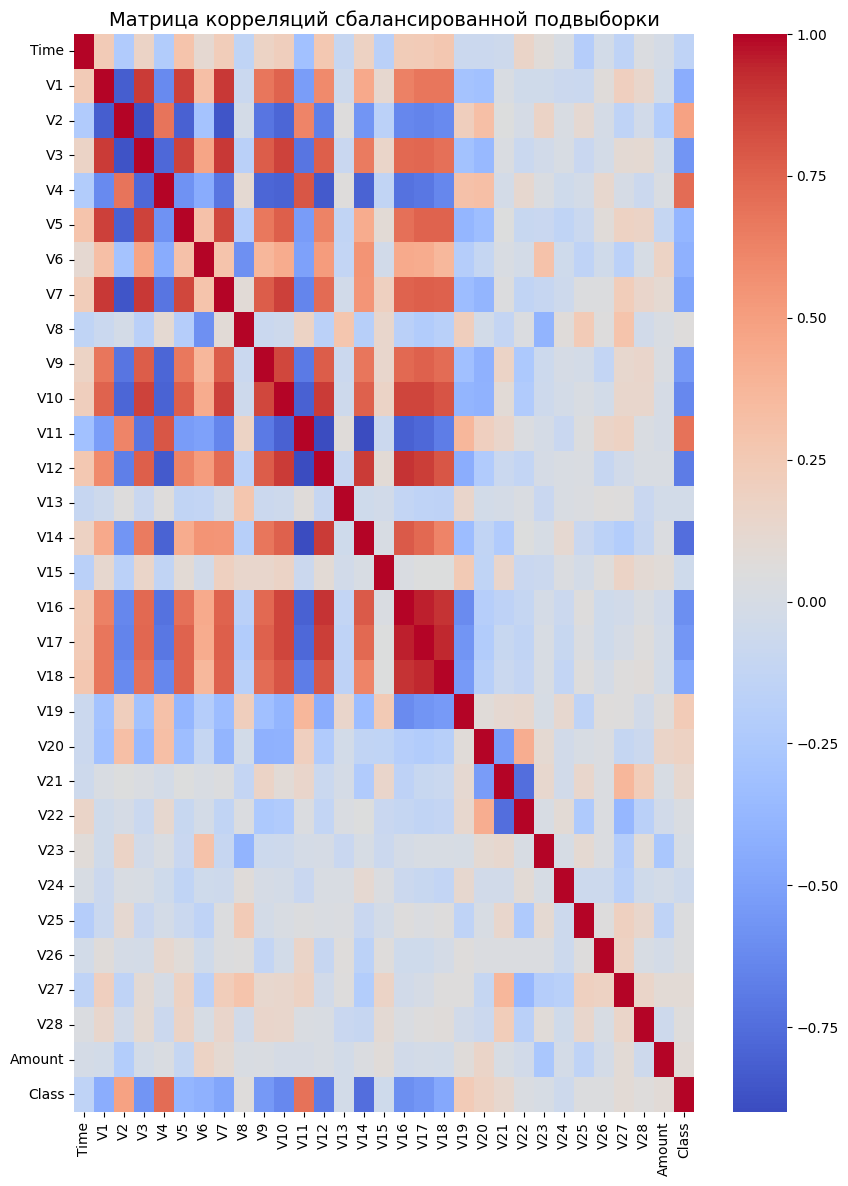

In [28]:
import seaborn as sns

f, ax = plt.subplots(1, 1, figsize=(10, 14))
# Построим матрицу корреляций
correlation_matrix = new_df.corr()

# Отображение матрицы корреляций с помощью heatmap
sns.heatmap(correlation_matrix,
            cmap="coolwarm",
            annot=False,  # Если хотите отобразить значения, замените False на True
            fmt=".2f",
            ax=ax,
            cbar=True)

ax.set_title('Матрица корреляций сбалансированной подвыборки', fontsize=14)

# Показ графика
plt.show()


### Выводы:
<ul>
<li><b>Отрицательные корреляции: </b> Какие признаки  имеют отрицательную корреляцию? Другими словами, чем ниже эти значения, тем больше вероятность того, что конечным результатом будет мошенническая операция.  </li>
<li> <b> Положительные корреляции: </b> Какие признаки  положительно коррелируют? То есть, чем выше эти значения, тем больше вероятность того, что конечным результатом будет мошенническая операция. </li>
</ul>


**Важно!**

Всегда проверяйте, используете ли вы сбалансированную подвыборку в корреляционной матрице, иначе на корреляционную матрицу повлияет сильный дисбаланс между классами.

Построим теперь Boxplot.

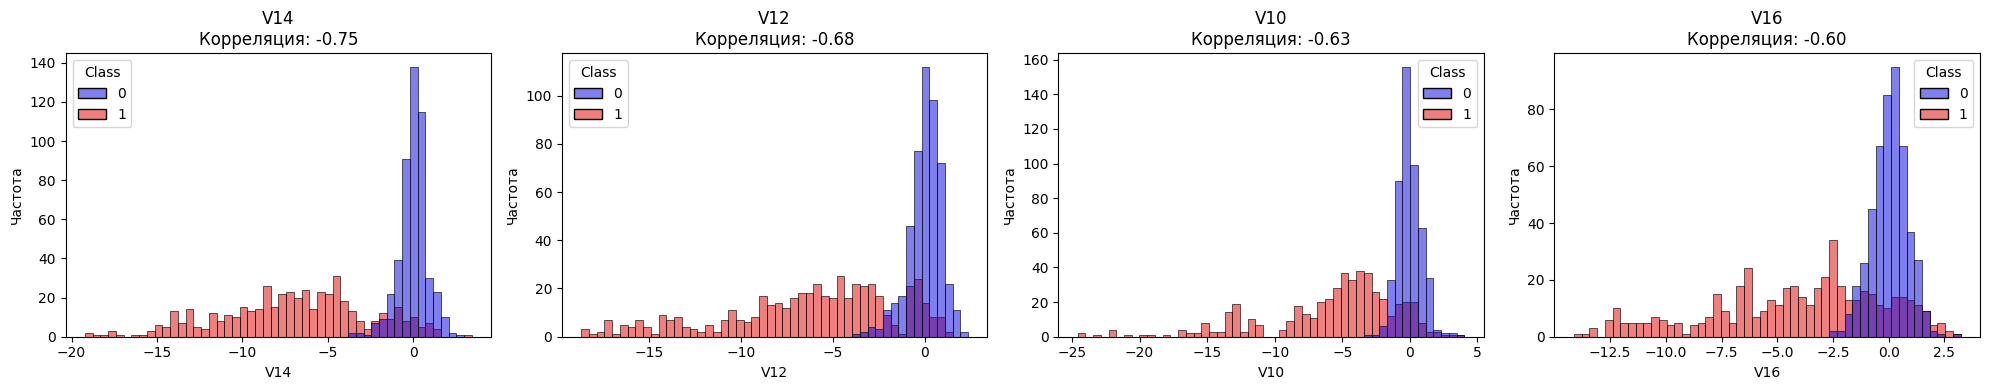

In [29]:
f, axes = plt.subplots(ncols=4, figsize=(20, 4))

# Отрицательные корреляции
# Выбираем 4 признака с наибольшей отрицательной корреляцией с классом
negative_correlations = correlation_matrix['Class'].sort_values()[:4]  # Берем 4 самых низких значения корреляции

# Строим гистограммы для этих признаков
for i, (feature, corr_value) in enumerate(negative_correlations.items()):
    sns.histplot(data=new_df, x=feature, hue='Class', ax=axes[i], bins=50, palette=["#0101DF", "#DF0101"])
    axes[i].set_title(f'{feature}\nКорреляция: {corr_value:.2f}', fontsize=12)
    axes[i].set_xlabel(feature, fontsize=10)
    axes[i].set_ylabel('Частота', fontsize=10)

plt.tight_layout()
plt.show()


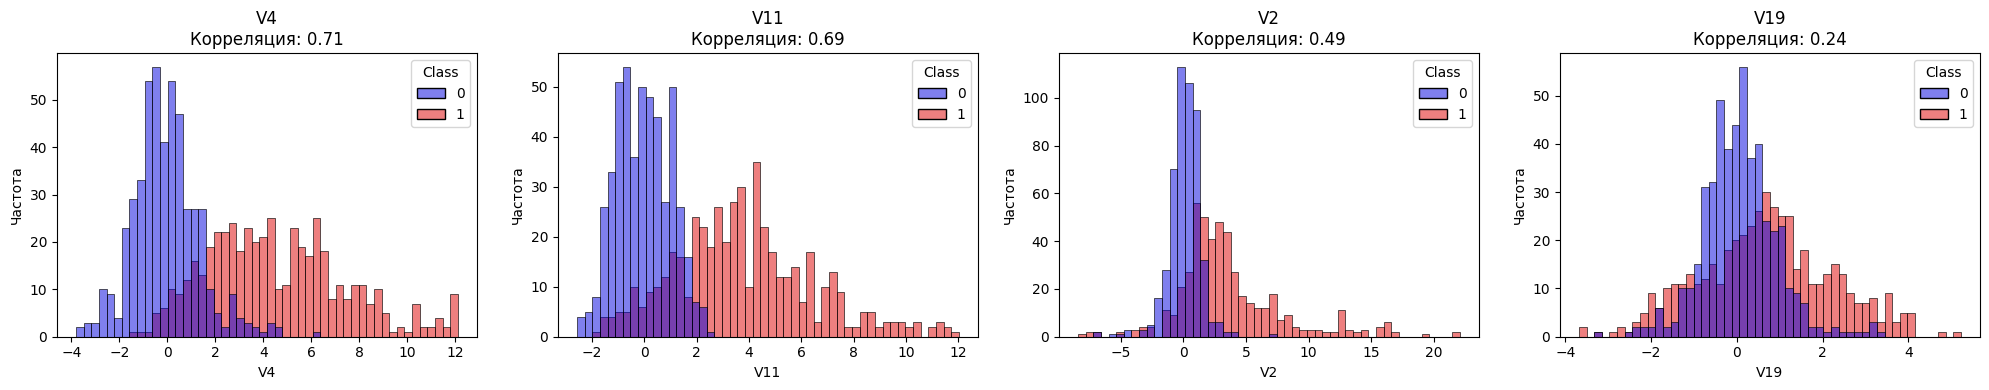

In [32]:
f, axes = plt.subplots(ncols=4, figsize=(20, 4))

# Положительные корреляции
# Выбираем 4 признака с наибольшей положительной корреляцией с классом
positive_correlations = correlation_matrix['Class'].sort_values(ascending=False)[1:5]  # Берем 4 самых высоких значения корреляции, исключая саму переменную 'Class'

# Строим гистограммы для этих признаков
for i, (feature, corr_value) in enumerate(positive_correlations.items()):
    sns.histplot(data=new_df, x=feature, hue='Class', ax=axes[i], bins=50, palette=["#0101DF", "#DF0101"])
    axes[i].set_title(f'{feature}\nКорреляция: {corr_value:.2f}', fontsize=12)
    axes[i].set_xlabel(feature, fontsize=10)
    axes[i].set_ylabel('Частота', fontsize=10)

plt.tight_layout()
plt.show()


# Какие выводы можно сделать по построенным Boxplot?

Напоминаю.

0 - это не мошеннические транзакции

1 - мошеннические транзакции

## Обработка выбросов

Наша основная цель в этом разделе - удалить выбросы из признаков, которые имеют высокую корреляцию с целевой переменной. Это положительно скажется на точности наших моделей.


### Метод межквартильного размаха:
<ul>
<li> <b>Interquartile Range (IQR): </b> Рассчитываем разницу между 75-м процентилем и 25-м процентилем. Наша цель - создать порог за пределами 75-го и 25-го процентилей, чтобы в случае, если какой-то экземпляр выборки преодолеет этот порог, он был удален.  </li>
<li> <b>Построить Boxplots: </b> С помощью boxplot легко увидеть 25-й и 75-й процентили и выбросы. </li>
</ul>

Надо быть внимательным к тому, как далеко мы хотим установить порог для удаления выбросов. Мы определяем порог путем умножения числа (например, 1.5) на интерквартильный размах. Чем выше этот порог, тем меньше выбросов будет обнаружено, а чем ниже этот порог, тем больше выбросов будет обнаружено.  <br><br>

Мы хотим больше сосредоточиться именно на сильных выбросах, а не просто на выбросах. Почему? Потому что удалив все выбросы, мы можем столкнуться с риском потери информации, что приведет к снижению точности наших моделей.


### Итого:
<ul>
<li> <b> Строим распределения </b>  </li>
<li><b>Определяем порог </b> </li>
<li> <b>Удаляем выбросы </b> </li>
<li> <b> Строим Boxplot </b> </li>
</ul>

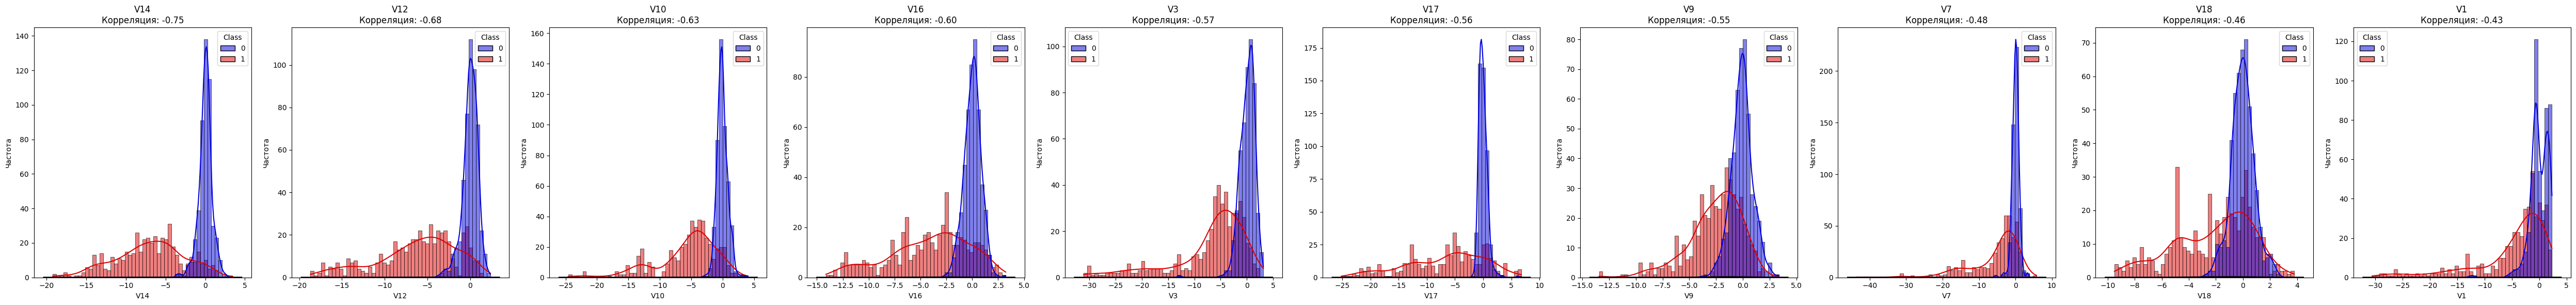

In [36]:
from scipy.stats import norm
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Строим распределения для признаков с отрицательной корреляцией
negative_correlations = correlation_matrix['Class'].sort_values(ascending=True)[:10]  # Берем топ 10 признаков с наибольшей отрицательной корреляцией

# Создаем достаточное количество подграфиков для всех признаков с отрицательной корреляцией
num_features = len(negative_correlations)
f, axes = plt.subplots(1, num_features, figsize=(5*num_features, 6))  # Размер будет динамически зависеть от количества признаков

# Если признаков несколько, то axes будет массивом, в противном случае одиночный объект
if num_features == 1:
    axes = [axes]

# Строим гистограммы для признаков с отрицательной корреляцией
for i, (feature, corr_value) in enumerate(negative_correlations.items()):
    ax = axes[i]  # Получаем соответствующий подграфик
    sns.histplot(data=new_df, x=feature, hue='Class', kde=True, ax=ax, bins=50, palette=["#0101DF", "#DF0101"])

    # Добавление нормального распределения
    mu, std = norm.fit(new_df[feature])  # находим параметры нормального распределения
    xmin, xmax = ax.get_xlim()
    x = np.linspace(xmin, xmax, 100)
    p = norm.pdf(x, mu, std)
    ax.plot(x, p, 'k', linewidth=2)

    ax.set_title(f'{feature}\nКорреляция: {corr_value:.2f}', fontsize=12)
    ax.set_xlabel(feature, fontsize=10)
    ax.set_ylabel('Частота', fontsize=10)

plt.tight_layout()
plt.show()


In [37]:
# Удаление выбросов из признака V17
v17_fraud = new_df['V17'].loc[new_df['Class'] == 1].values
q25, q75 = np.percentile(v17_fraud, 25), np.percentile(v17_fraud, 75)
print('Квартиль 25: {} | Квартиль 75: {}'.format(q25, q75))
v17_iqr = q75 - q25
print('iqr: {}'.format(v17_iqr))

v17_cut_off = v17_iqr * 1.5
v17_lower, v17_upper = q25 - v17_cut_off, q75 + v17_cut_off
print('Порог: {}'.format(v17_cut_off))
print('V17 нижняя граница: {}'.format(v17_lower))
print('V17 верхняя граница: {}'.format(v17_upper))

outliers = [x for x in v17_fraud if x < v17_lower or x > v17_upper]
print('Количество выбросов: {}'.format(len(outliers)))

new_df_without_outliers  = new_df.drop(new_df[(new_df['V17'] > v17_upper) | (new_df['V17'] < v17_lower)].index)
print('----' * 44)



#### Для остальных признаков на основе V17 описать функцию, в качастве параметра которой будут вытупать выбросы других признаков
### Написать вызов функции по нужным признакам

Квартиль 25: -11.945057187644576 | Квартиль 75: -1.34193993162032
iqr: 10.603117256024255
Порог: 15.904675884036383
V17 нижняя граница: -27.84973307168096
V17 верхняя граница: 14.562735952416062
Количество выбросов: 0
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


Для признака V1 - квартиль 25: -2.7982597953775725 | квартиль 75: 0.917022677827606
IQR для V1: 3.7152824732051783
Порог для V1: 5.5729237098077675
V1 нижняя граница: -8.37118350518534
V1 верхняя граница: 6.489946387635373
Количество выбросов для V1: 96
Для признака V2 - квартиль 25: -0.20818909182414325 | квартиль 75: 1.9606096468320675
IQR для V2: 2.1687987386562106
Порог для V2: 3.253198107984316
V2 нижняя граница: -3.4613871998084593
V2 верхняя граница: 5.213807754816384
Количество выбросов для V2: 46
Для признака V3 - квартиль 25: -3.0757236497563922 | квартиль 75: 0.6791826471712514
IQR для V3: 3.7549062969276434
Порог для V3: 5.632359445391465
V3 нижняя граница: -8.708083095147858
V3 верхняя граница: 6.311542092562717
Количество выбросов для V3: 11
Для признака V4 - квартиль 25: -0.4433984745932845 | квартиль 75: 2.816295804150815
IQR для V4: 3.2596942787440994
Порог для V4: 4.889541418116149
V4 нижняя граница: -5.332939892709434
V4 верхняя граница: 7.705837222266965
Количество 

IndexError: index 4 is out of bounds for axis 0 with size 4

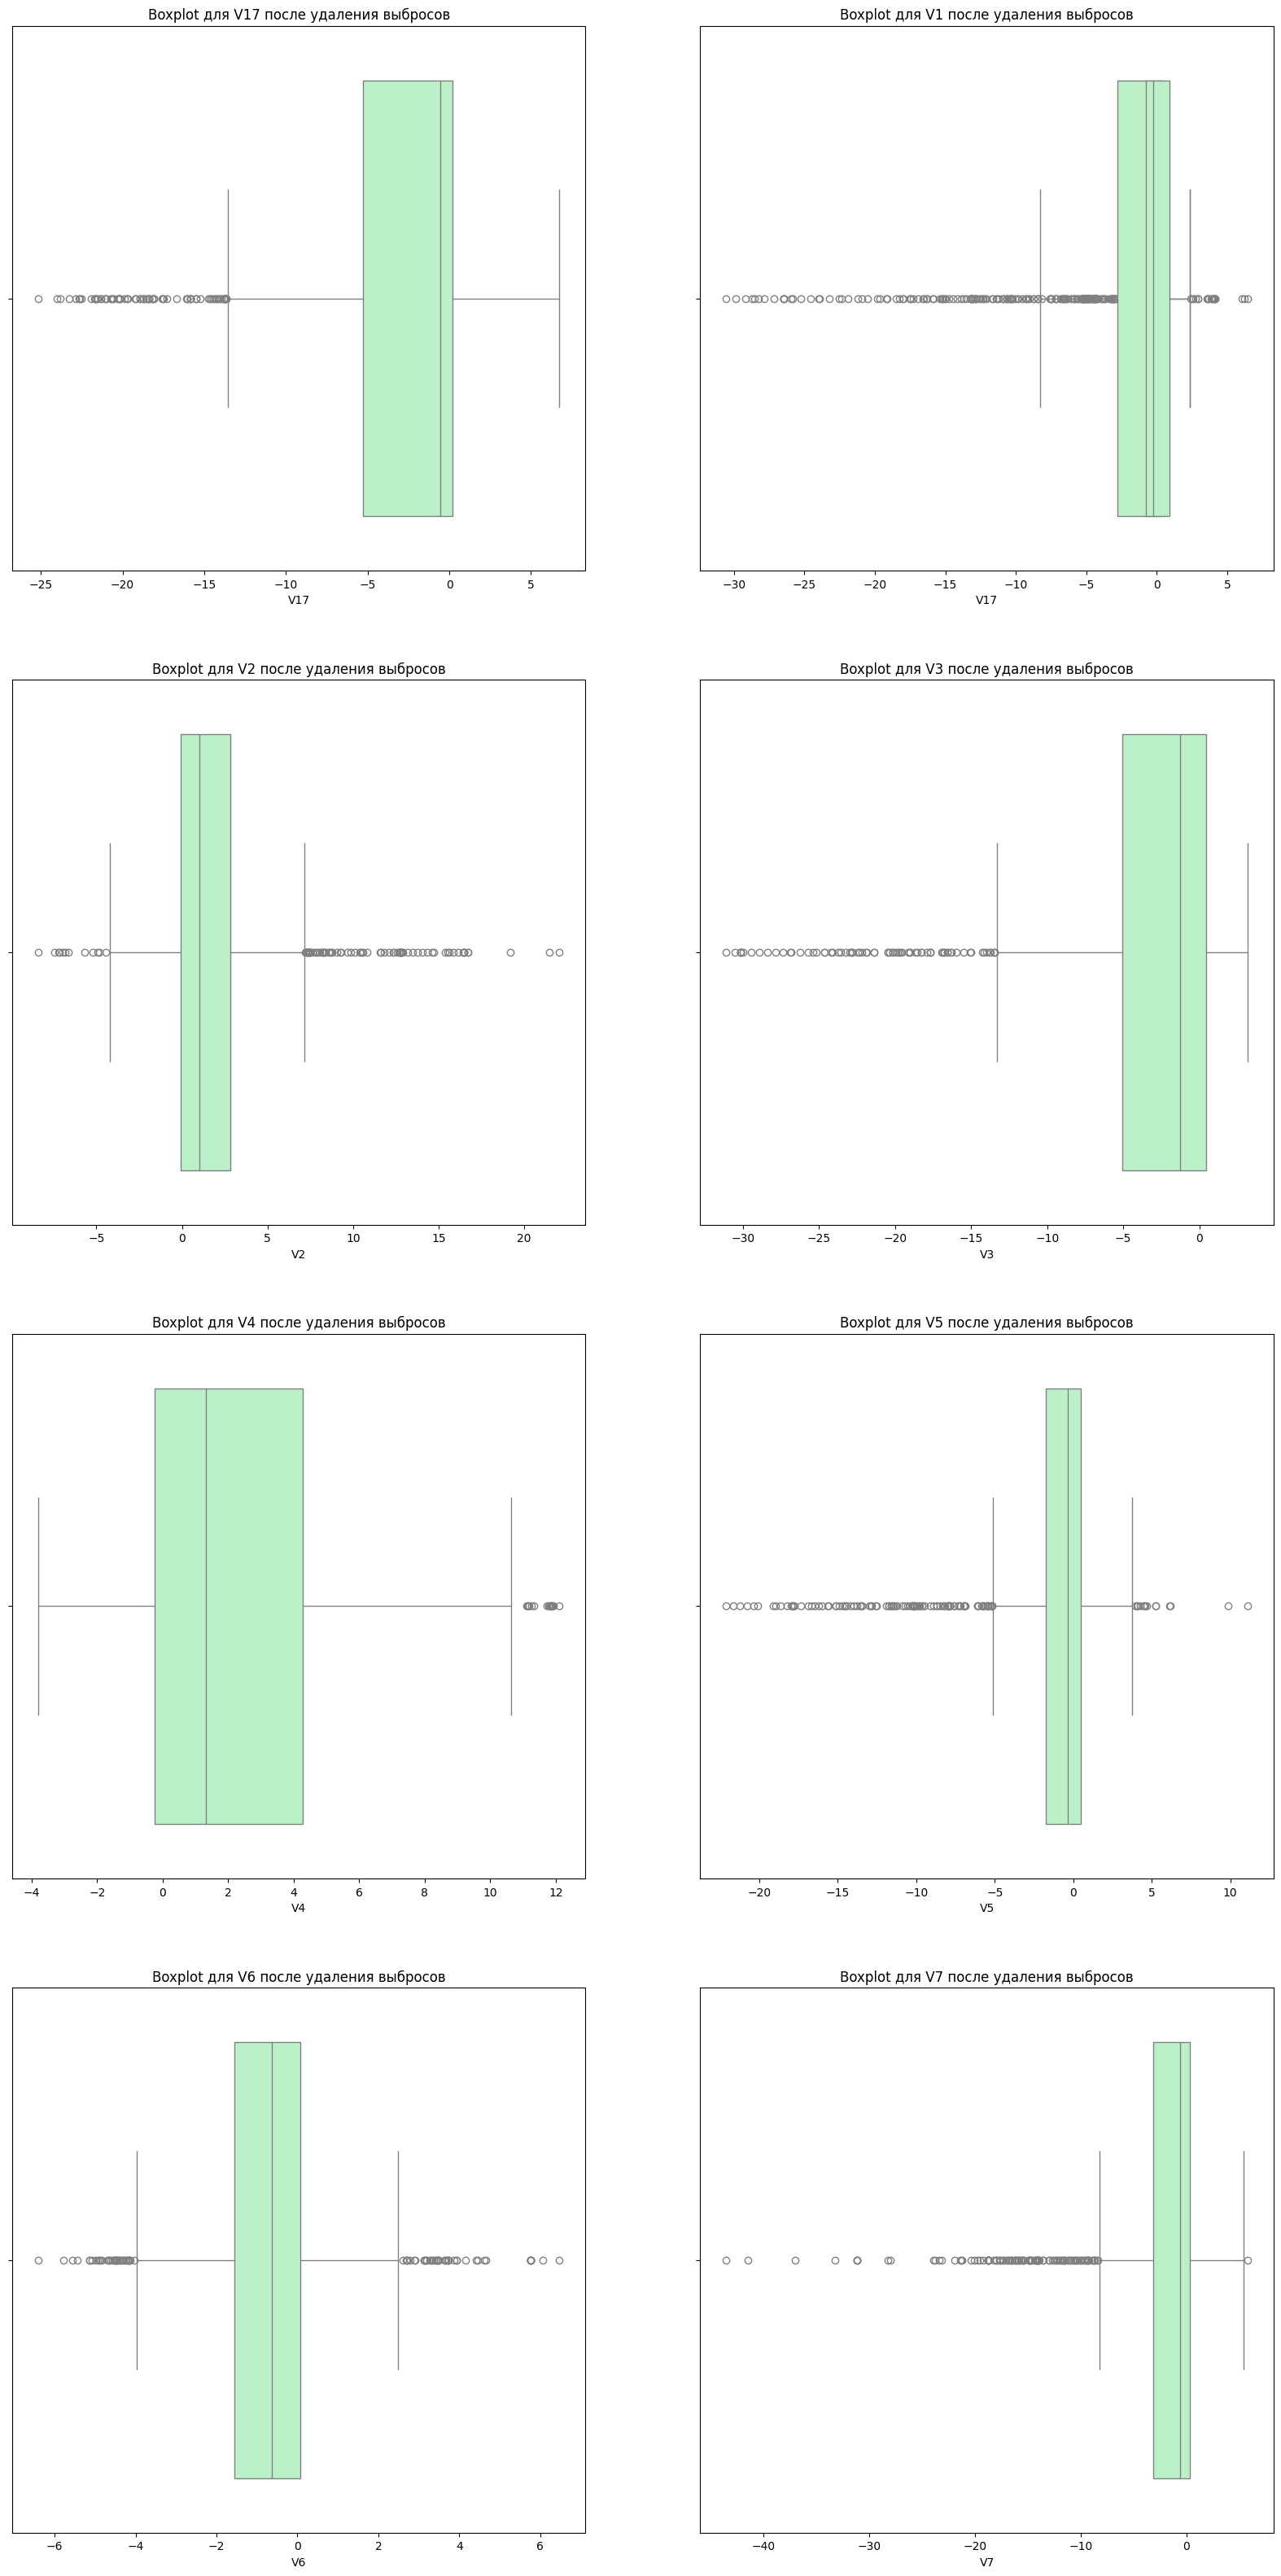

In [38]:
# Функция для удаления выбросов на основе межквартильного размаха (IQR) для других признаков
def remove_outliers(df, column):
    # Получаем значения квартилей для признака
    q25, q75 = np.percentile(df[column], 25), np.percentile(df[column], 75)
    print(f'Для признака {column} - квартиль 25: {q25} | квартиль 75: {q75}')
    iqr = q75 - q25
    print(f'IQR для {column}: {iqr}')

    # Вычисляем пороги для выбросов
    cut_off = iqr * 1.5
    lower, upper = q25 - cut_off, q75 + cut_off
    print(f'Порог для {column}: {cut_off}')
    print(f'{column} нижняя граница: {lower}')
    print(f'{column} верхняя граница: {upper}')

    # Определяем выбросы
    outliers = df[(df[column] < lower) | (df[column] > upper)]
    print(f'Количество выбросов для {column}: {len(outliers)}')

    # Удаляем выбросы
    df_without_outliers = df.drop(outliers.index)
    return df_without_outliers

# Применяем функцию для других признаков (например, V1, V2, V3, и т.д.)
columns_to_check = ['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8']  # Пример списка признаков для проверки

for column in columns_to_check:
    new_df = remove_outliers(new_df, column)

# Визуализация: Boxplot для признака V17 до и после удаления выбросов
f, ax = plt.subplots(4, 2, figsize=(20,40))

colors = ['#B3F9C5', '#f9c5b3']

# Boxplot для признака V17 после удаления выбросов
sns.boxplot(data=new_df_without_outliers, x='V17', ax=ax[0, 0], palette=colors)
ax[0, 0].set_title('Boxplot для V17 после удаления выбросов')

# Boxplot для признака V17 до удаления выбросов
sns.boxplot(data=new_df, x='V17', ax=ax[0, 1], palette=colors)
ax[0, 1].set_title('Boxplot для V17 до удаления выбросов')

# Boxplot для других признаков
for i, column in enumerate(columns_to_check):
    row = (i + 1) // 2
    col = (i + 1) % 2
    sns.boxplot(data=new_df_without_outliers, x=column, ax=ax[row, col], palette=colors)
    ax[row, col].set_title(f'Boxplot для {column} после удаления выбросов')

plt.tight_layout()
plt.show()


In [39]:
# теперь у нас в датафрейме new_df будут лежать данные без выбросов.

new_df = new_df_without_outliers

### Понижение размерности и кластеризация

Для того, чтобы убедиться, что наши классы являются разделимыми (иначе строить модели нет смысла), выполним кластеризацию с помощью трех различных техник кластеризации.



T-SNE заняло 8.78 сек
PCA заняло 0.02 сек
Truncated SVD заняло 0.00 сек


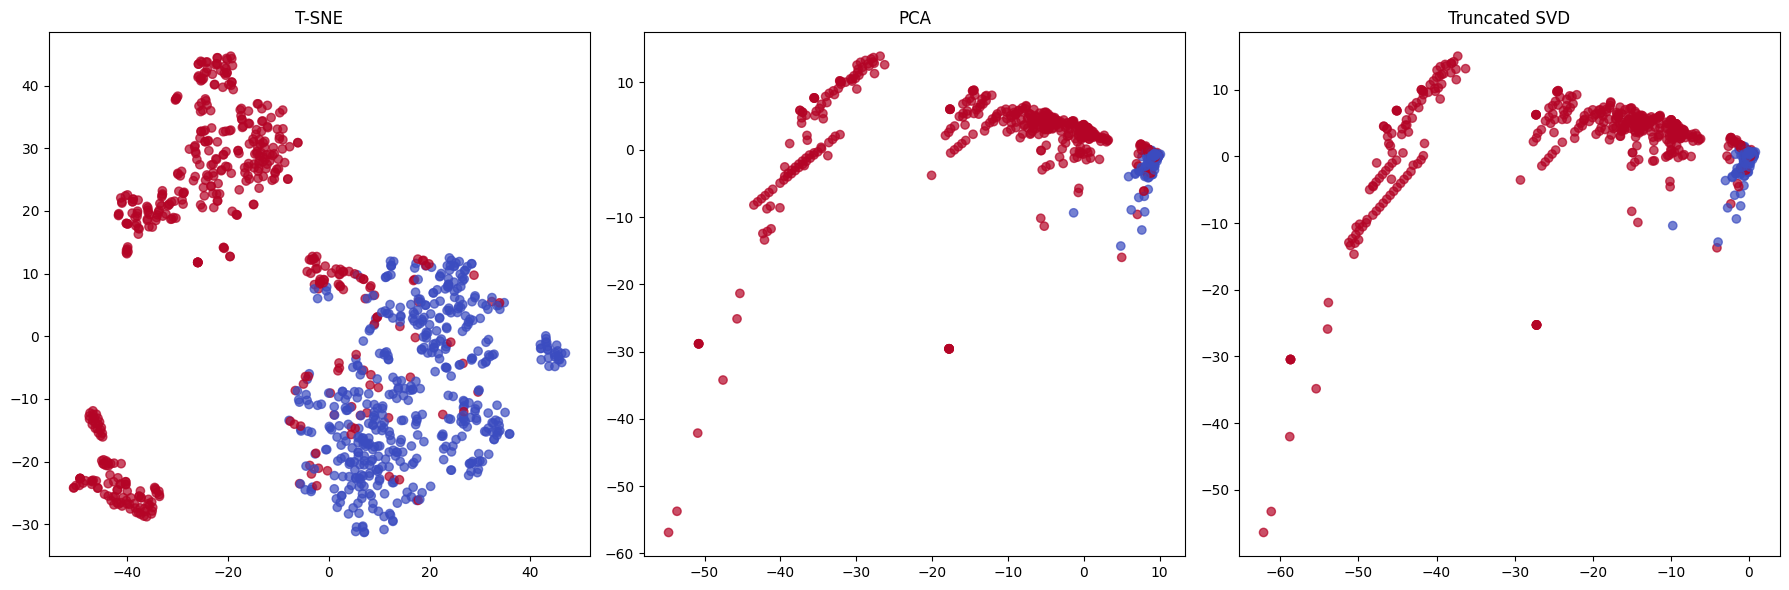

In [40]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, TruncatedSVD
import matplotlib.pyplot as plt
import time

# Предполагается, что DataFrame new_df уже загружен и подготовлен
X = new_df.drop('Class', axis=1)
y = new_df['Class']

X.drop(['Time', 'Amount'], axis=1, inplace=True)  # Удаляем Time и Amount

# T-SNE алгоритм
t0 = time.time()
tsne = TSNE(n_components=2, random_state=42)
X_reduced_tsne = tsne.fit_transform(X)
t1 = time.time()
print("T-SNE заняло {:.2f} сек".format(t1 - t0))

# PCA алгоритм
t0 = time.time()
pca = PCA(n_components=2)
X_reduced_pca = pca.fit_transform(X)
t1 = time.time()
print("PCA заняло {:.2f} сек".format(t1 - t0))

# Truncated SVD алгоритм
t0 = time.time()
svd = TruncatedSVD(n_components=2)
X_reduced_svd = svd.fit_transform(X)
t1 = time.time()
print("Truncated SVD заняло {:.2f} сек".format(t1 - t0))

# Визуализация результатов
f, axes = plt.subplots(1, 3, figsize=(18, 6))

# T-SNE
axes[0].scatter(X_reduced_tsne[:, 0], X_reduced_tsne[:, 1], c=y, cmap='coolwarm', alpha=0.7)
axes[0].set_title('T-SNE')

# PCA
axes[1].scatter(X_reduced_pca[:, 0], X_reduced_pca[:, 1], c=y, cmap='coolwarm', alpha=0.7)
axes[1].set_title('PCA')

# Truncated SVD
axes[2].scatter(X_reduced_svd[:, 0], X_reduced_svd[:, 1], c=y, cmap='coolwarm', alpha=0.7)
axes[2].set_title('Truncated SVD')

plt.tight_layout()
plt.show()

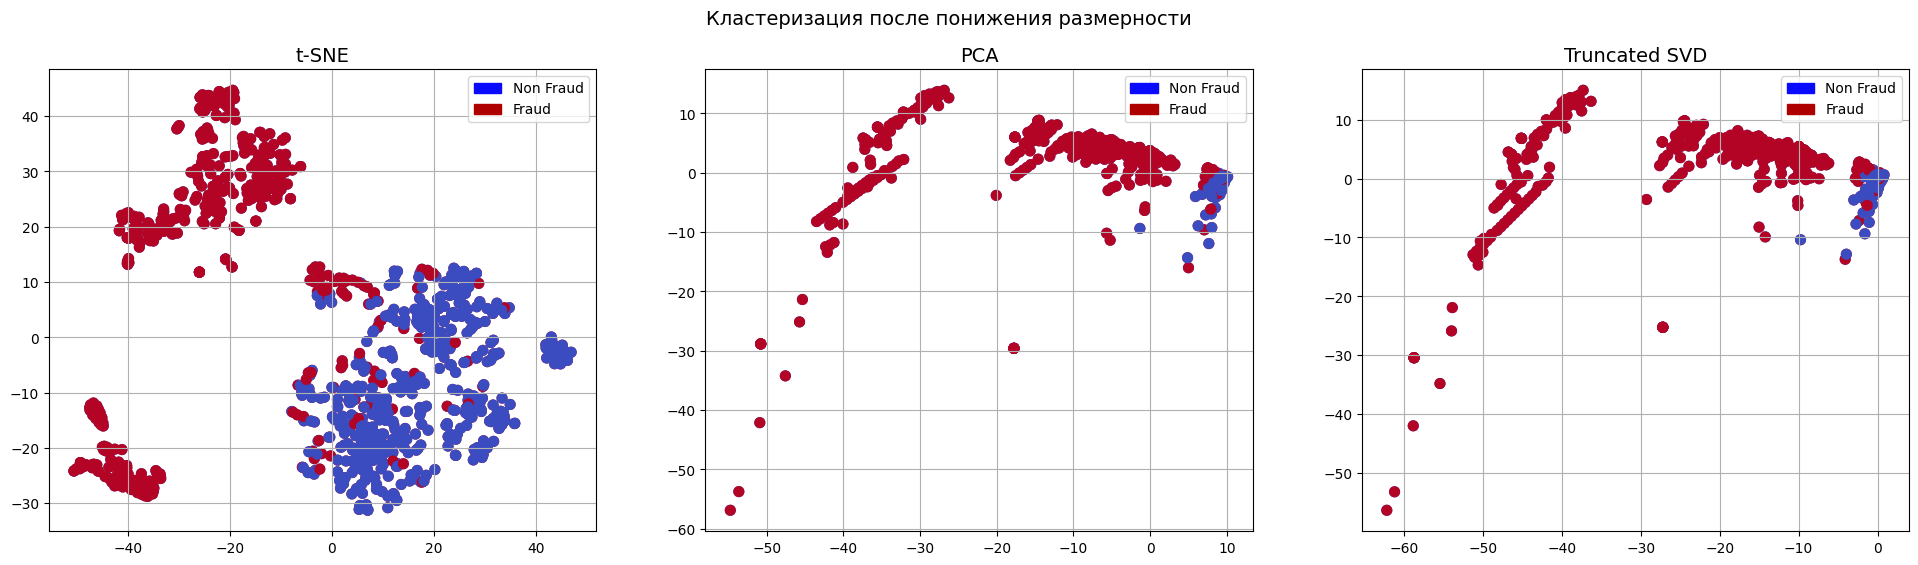

In [41]:
import matplotlib.patches as mpatches

# Создаем субплоты
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24,6))
f.suptitle('Кластеризация после понижения размерности', fontsize=14)

# Создание легенды
blue_patch = mpatches.Patch(color='#0A0AFF', label='Non Fraud')
red_patch = mpatches.Patch(color='#AF0000', label='Fraud')

# t-SNE scatter plot
ax1.scatter(X_reduced_tsne[:, 0], X_reduced_tsne[:, 1], c=(y == 0), cmap='coolwarm', label='Non Fraud', linewidths=2)
ax1.scatter(X_reduced_tsne[:, 0], X_reduced_tsne[:, 1], c=(y == 1), cmap='coolwarm', label='Fraud', linewidths=2)
ax1.set_title('t-SNE', fontsize=14)
ax1.grid(True)
ax1.legend(handles=[blue_patch, red_patch])

# PCA scatter plot
ax2.scatter(X_reduced_pca[:, 0], X_reduced_pca[:, 1], c=(y == 0), cmap='coolwarm', label='Non Fraud', linewidths=2)
ax2.scatter(X_reduced_pca[:, 0], X_reduced_pca[:, 1], c=(y == 1), cmap='coolwarm', label='Fraud', linewidths=2)
ax2.set_title('PCA', fontsize=14)
ax2.grid(True)
ax2.legend(handles=[blue_patch, red_patch])

# Truncated SVD scatter plot
ax3.scatter(X_reduced_svd[:, 0], X_reduced_svd[:, 1], c=(y == 0), cmap='coolwarm', label='Non Fraud', linewidths=2)
ax3.scatter(X_reduced_svd[:, 0], X_reduced_svd[:, 1], c=(y == 1), cmap='coolwarm', label='Fraud', linewidths=2)
ax3.set_title('Truncated SVD', fontsize=14)
ax3.grid(True)
ax3.legend(handles=[blue_patch, red_patch])

# Показать все графики
plt.show()


<h3> Выводы: </h3>
<ul>
<li>Алгоритм t-SNE может довольно точно кластеризовать случаи мошенничества и не мошенничества в нашем наборе данных. </li>
<li> Классы целевой переменной однозначно разделимы, а значит мы можем строить модели! </li>
</ul>

## Продолжение следует .....



<h3 style="text-align: center;">Материалы для изучения scikit-learn:<b></b></h3>

*1) Официальный сайт с подробными описаниями моделей и методов : https://scikit-learn.org/stable/user_guide.html*

*2) Полезный репозиторий с блокнотами: https://github.com/gmonce/scikit-learn-book*

*3) Хороший курс с упражнениями: https://inria.github.io/scikit-learn-mooc/*

In [ ]:
new_df.to_csv('/content/drive/MyDrive/Colab Notebooks/data/creditcard_short.csv')